# Forecasting temperature with SARIMA
- toc: true
- author: Andreas Palmgren
- use_math: true

## 1. Introduction

> Weather forecasting is a difficult but important task. All predictions have a degree of uncertainty, but the chaotic character of our atmosphere causes weather forecasting to become especially challenging. As you might have experienced yourself, day-to-day weather prediction becomes unreliable more than a week into the future. 

> **The aim for this project is to find an appropriate ARIMA model able to forecast monthly mean air temperature in Stockholm.**



In [22]:
#collapse
library(plotly)
library(ggplot2)
library(ggfortify)
library(repr)
library(tidyr)
library(tsibble)
library(TSstudio)
library(zoo)
library(dplyr)
library(tseries)
library(forecast)

library(ggridges)
library(viridis)
library(hrbrthemes)
library(heatmaply)
library(gridExtra)

Sys.setlocale(locale = "English")
windowsFonts(Times=windowsFont("Times New Roman"))

options(repr.plot.width=14, repr.plot.height=8)

# Center position of plots
IRdisplay::display_html('<style>.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}</style>')

th <- theme(text=element_text(size = 20, face = "bold",  family="Times"),
        plot.title = element_text(size = 25, face = "bold",  family="Times", hjust = 0.5),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid = element_line(size = 0.25, linetype = 'solid',
                                colour = "grey80"))

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

## 2. Data source
> The underlying data consist of historical weather observation of monthly mean air temperature in Stockholm. 


>**Reference**
Anders Moberg (2021) Stockholm Historical Weather Observations — Monthly mean air temperatures since 1756. Dataset version 3. Bolin Centre Database. https://doi.org/10.17043/stockholm-historical-monthly-temperature-3


In [2]:
train_df <- read.csv("dataset/train_stockholm_monthly_mean_temperature.csv", sep=';')
test_df <- read.csv("dataset/test_stockholm_monthly_mean_temperature.csv", sep=';')
df <- rbind(train_df, test_df)
head(df)

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980,-4.7,-6.2,-3.1,4.8,7.8,15.6,16.8,14.6,12.8,5.7,0.0,-0.8
2,1981,-4.0,-2.7,-2.2,3.9,10.8,12.6,16.4,14.6,11.7,6.5,1.1,-5.7
3,1982,-7.2,-4.0,1.1,4.1,9.4,12.5,17.4,17.0,12.3,7.6,4.5,0.3
4,1983,0.7,-3.8,-0.1,4.0,10.2,14.0,18.0,17.8,12.4,7.5,1.2,-1.1
5,1984,-3.0,-1.7,-2.0,5.3,10.9,13.3,15.3,16.4,10.6,8.9,4.3,0.8
6,1985,-9.0,-11.6,-1.7,1.6,9.0,13.6,15.9,15.4,10.3,8.0,0.3,-4.3


In [3]:
#collapse
train <- ts(as.vector(t(as.matrix(train_df[,-1]))), start=c(min(train_df$year), 1), 
            end=c(max(train_df$year), 12), frequency =12)

test <- ts(as.vector(t(as.matrix(test_df[,-1]))), start=c(2017, 1), 
            end=c(2020, 12), frequency =12)

df_ts <- ts(as.vector(t(as.matrix(df[,-1]))), start=c(1980, 1), 
            end=c(2020, 12), frequency =12)

# Reshaped version for visualization
train_reshape <- data.frame(date=as.Date(as.yearmon(time(train))), temp=as.matrix(train))
train_reshape$month <- format(train_reshape$date, "%b")
train_reshape$year <- format(train_reshape$date, "%Y")

## 3. Data analysis
### 3.1 Data visualization
> We must gain a better understanding of our time series by inspection, and the most intuitive way of doing this is through a line plot. As seen in the figure below, our time series is clearly not stationary. It does not appear to be any obvious trend but a seasonal pattern can be seen and we should investigate this further. Our dataset might suffer from seasonal outliers, as some peaks deviate heavily from others.

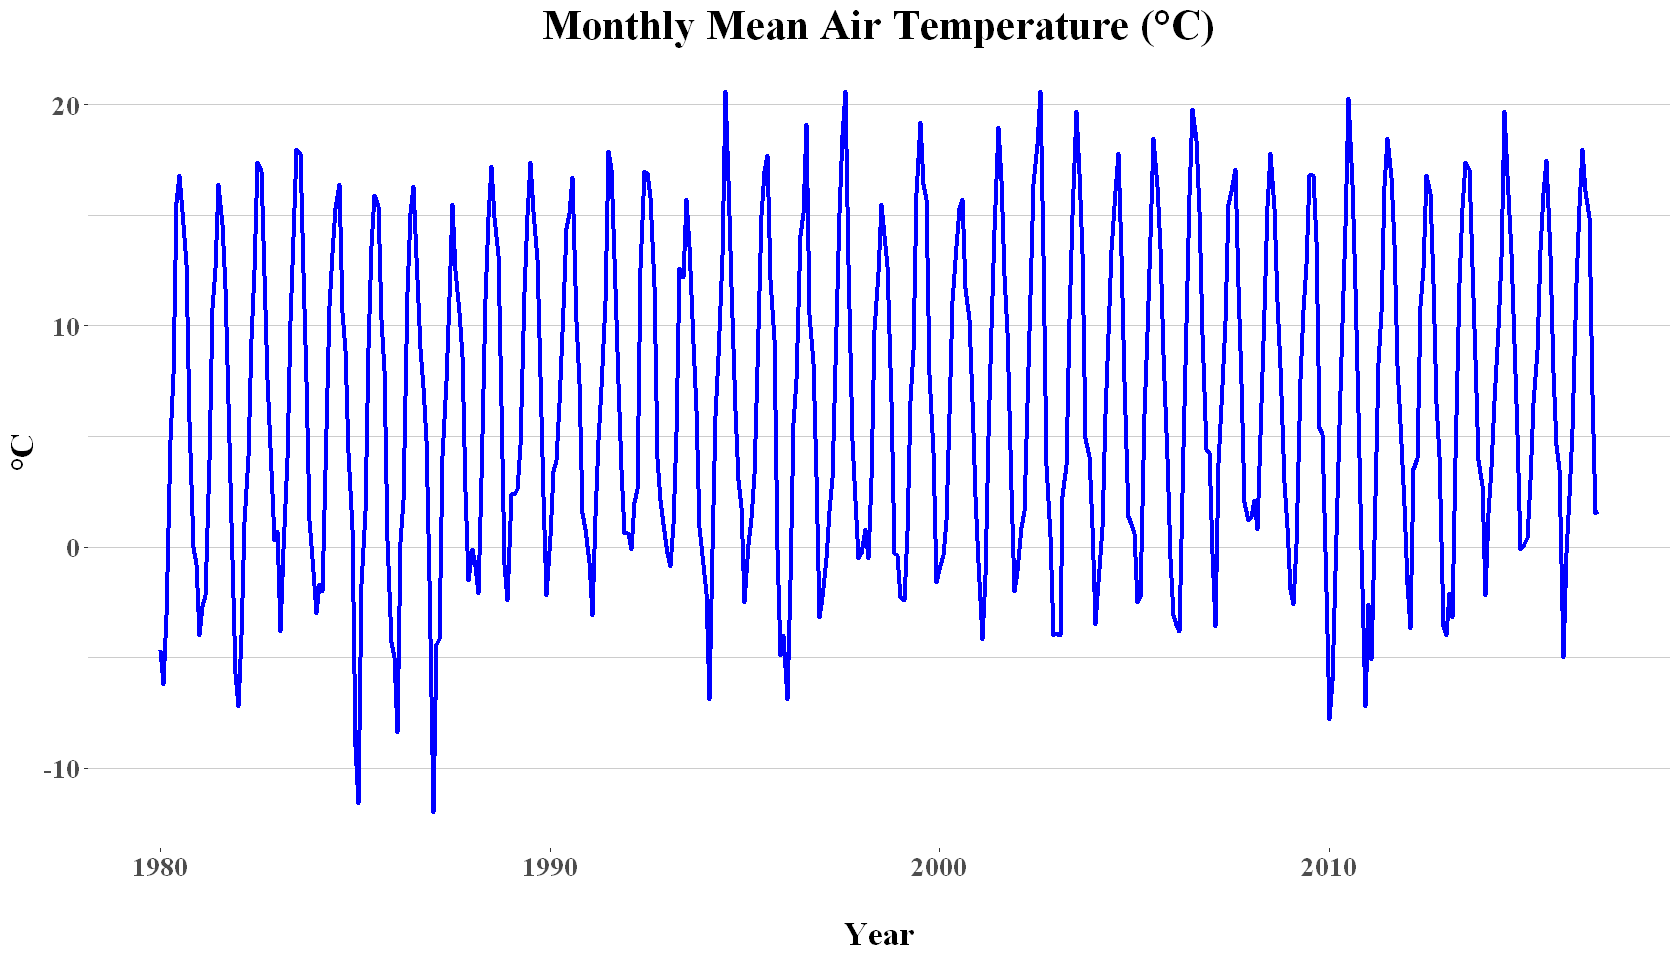

In [4]:
#collapse
ggplot(data=train_reshape, aes(x=date, y=temp, group=1))+
    ggtitle("Monthly Mean Air Temperature (°C)")+
    geom_line(color="blue", size=1.2)+
    xlab("\nYear") + ylab("°C") +
    th + theme(legend.position="none")

> Dealing with monthly data, a ridgeplot over all months gives further insight. Annual seasonal pattern is strong. January and February might suffer from outliers and should be investigated. 

Picking joint bandwidth of 0.787



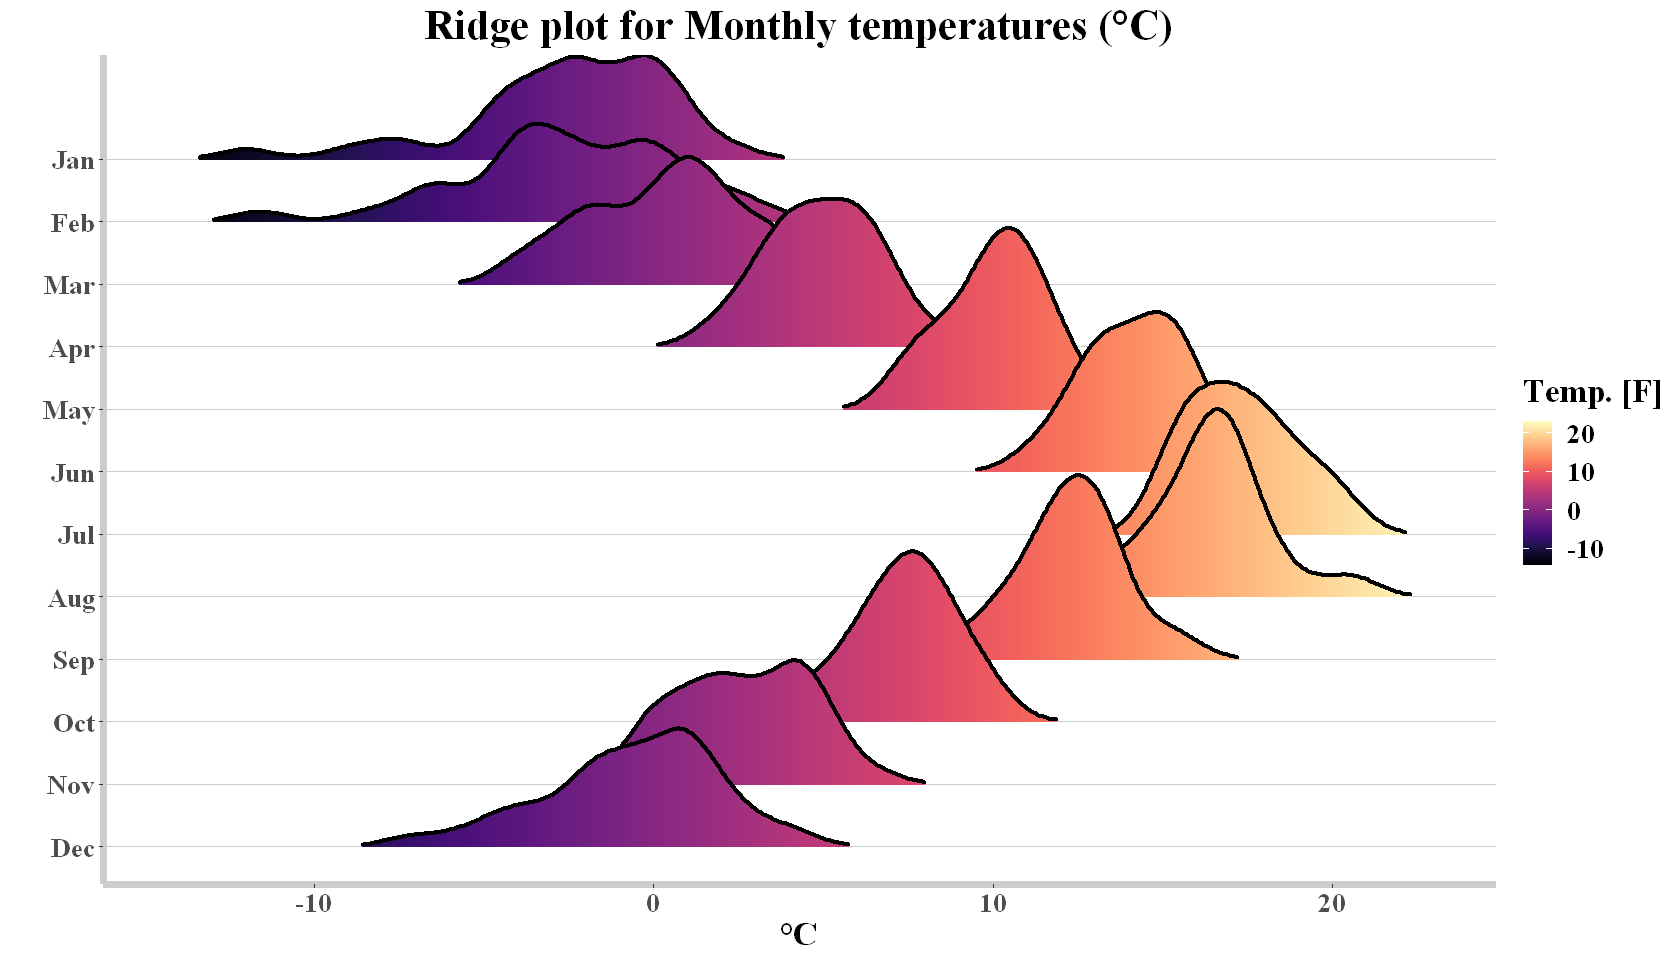

In [5]:
#collapse
ggplot(train_reshape, aes(x = temp, y = factor(month, levels = month.abb), fill = ..x..))+
    geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01, lwd=1.2) +
    scale_fill_viridis(name = "Temp. [F]", option = "A") +
    labs(title = 'Ridge plot for Monthly temperatures (°C)') +
    scale_y_discrete(limits=rev) +
    xlab("°C") + ylab("") +
    th + theme(axis.line = element_line(size = 2, colour = "grey80"))

> Boxplot is a better alternative to visualize outliers. Variance differ between months.

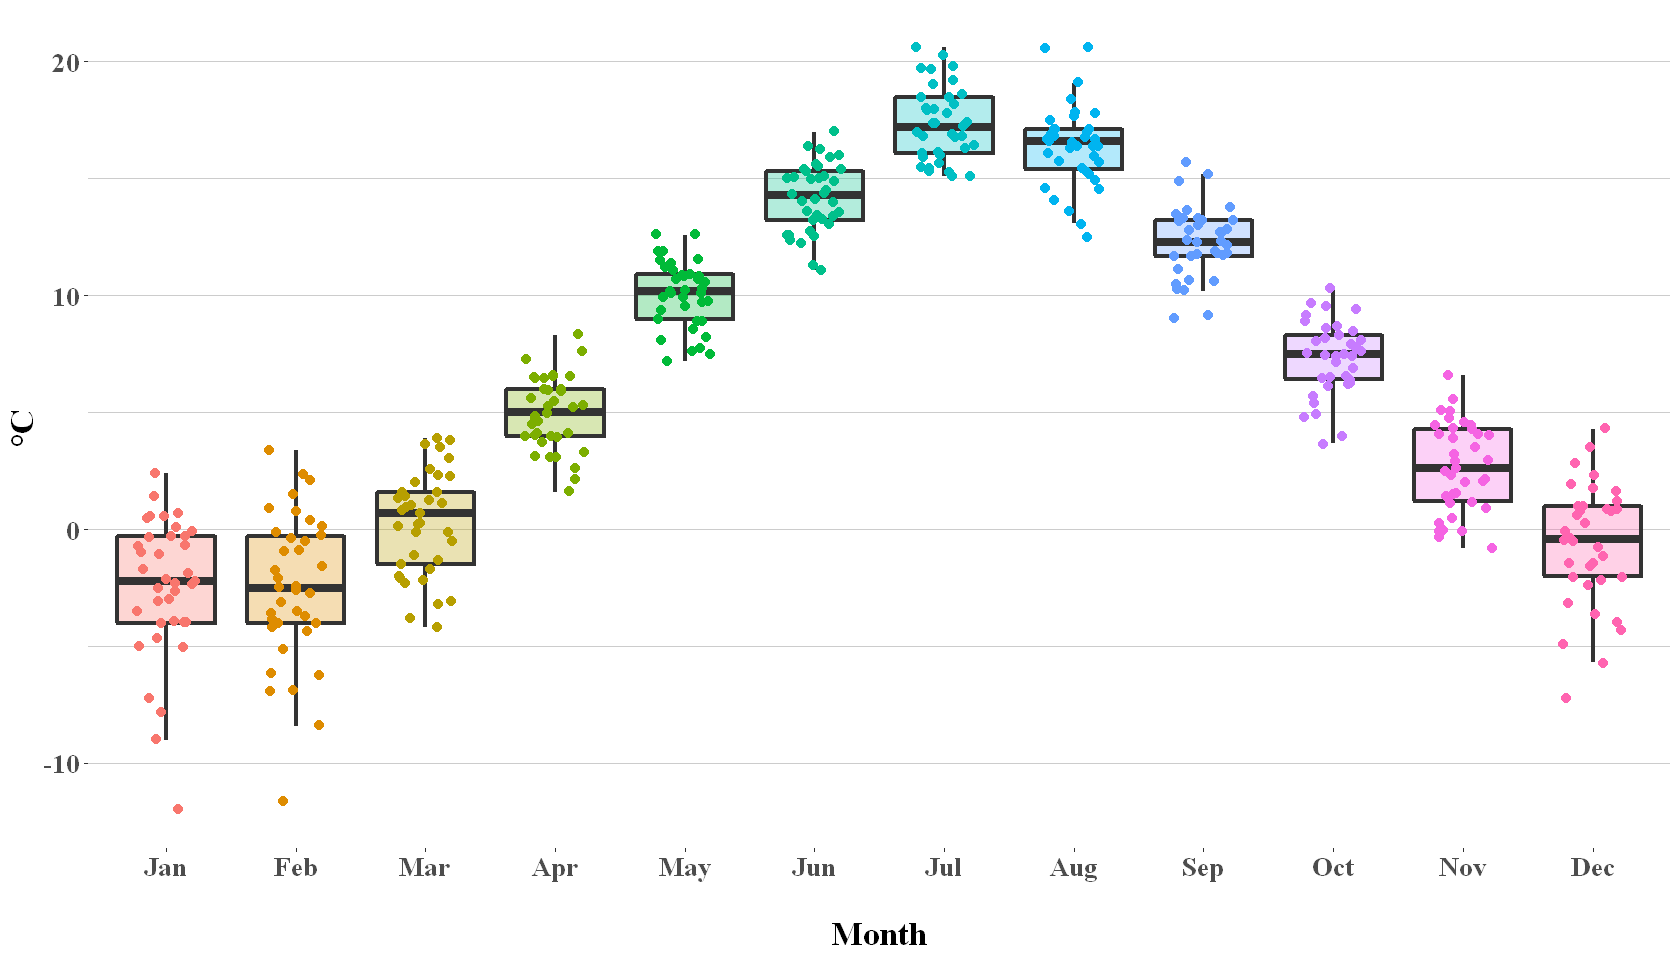

In [6]:
#collapse
ggplot(train_reshape, aes(x = factor(month, levels = month.abb), y = temp, fill=factor(month, levels = month.abb)))+
    geom_boxplot(outlier.alpha = 0, alpha=0.3, lwd=1.2) +
    geom_jitter(size=2.4, position=position_jitter(0.23), aes(colour=factor(month, levels = month.abb)))+ 
    xlab("\nMonth") + ylab("°C") +
    th + theme(legend.position="none")

> By inspecting a seasonal subseries plot, we see how potential outliers reside in the earlier years. Our dataset might suffer from strucural breaks. 

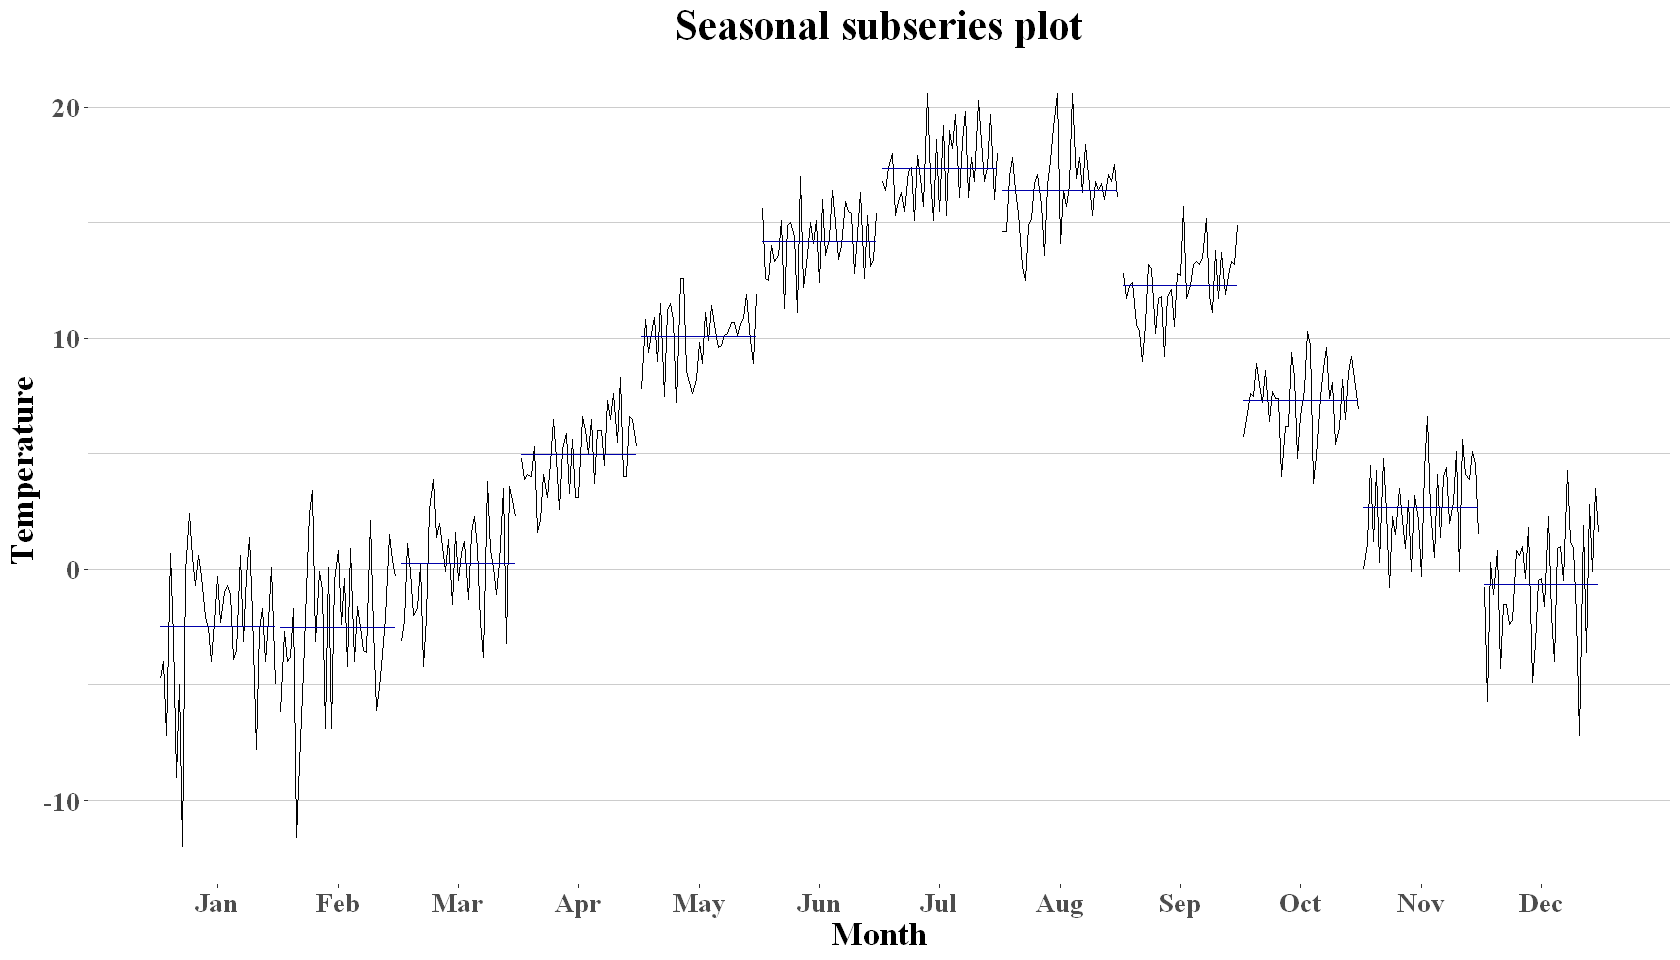

In [7]:
#collapse
ggsubseriesplot(train) +
    ylab("Temperature") +
    ggtitle("Seasonal subseries plot") +
    th

> Dealing with temperature, a heatmap could also be an intuitive way of visualizing our dataset. The lowest temperatures are recorded during February 1985 and January 1987. We have already identified these outliers. But it also appears to become warmer in July and August after 1993.. 

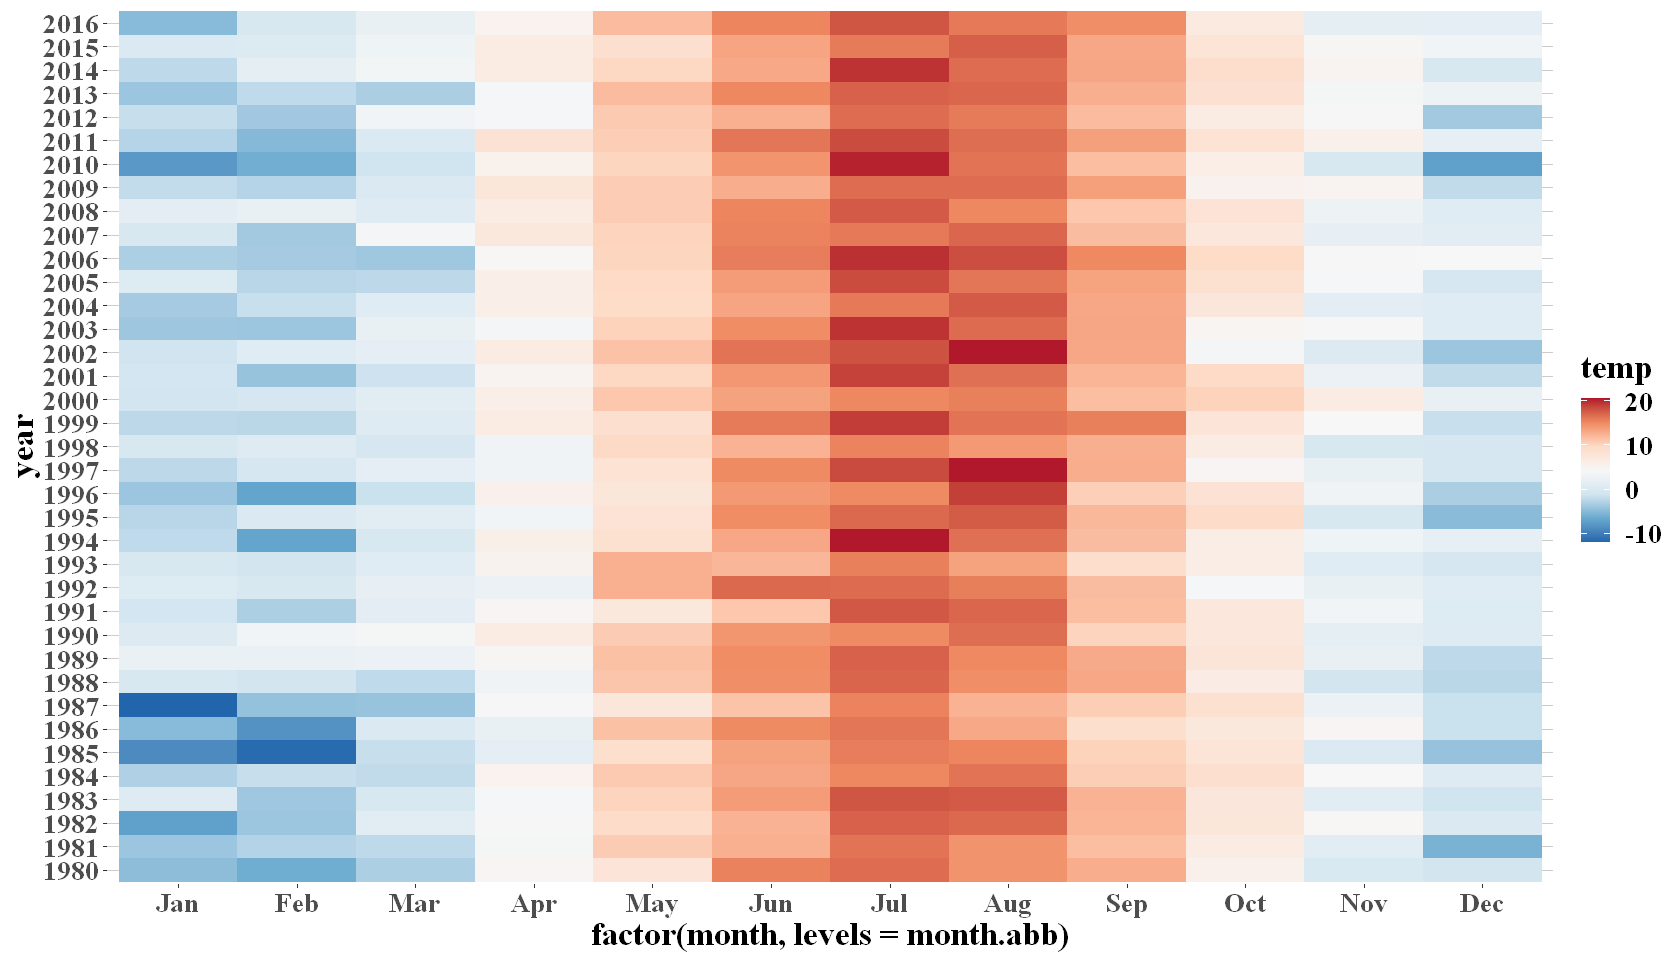

In [8]:
#collapse
dt <- as.matrix(train_df[,-1])

ggplot(train_reshape, aes(factor(month, levels = month.abb), year, fill= temp)) + 
    geom_tile() +
    scale_fill_distiller(palette = "RdBu") +
    th

> Our seasonal component is clear at this point and is once again confirmed by plotting the sample autocorrelation function (ACF). No clear trend seem to be apparent but strong seasonal component.

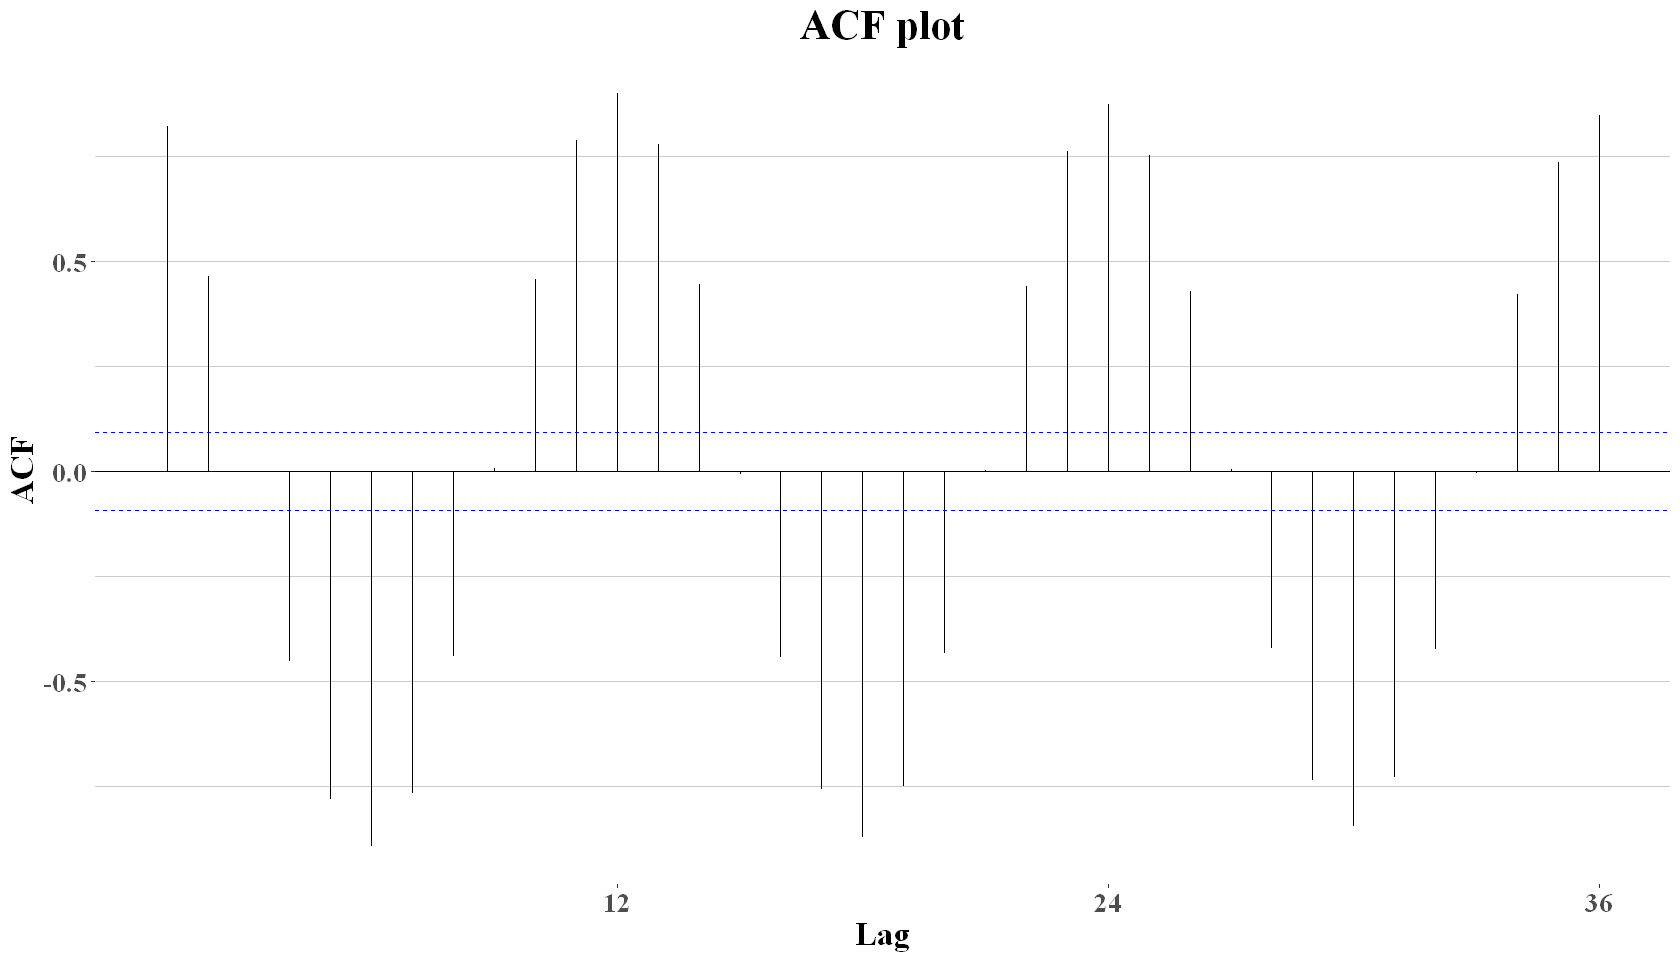

In [9]:
#collapse
ggAcf(train, lag.max = 36) +
    labs(title = 'ACF plot')+
    th

> With monthly data, our dominating period is obviosly 12. The periodogram can be useful to identify other periods or if one is unsure of dominating period. Following periodogram is calculated using a fast Fourier transform and smooth through a series of modified Daniell smoothers.

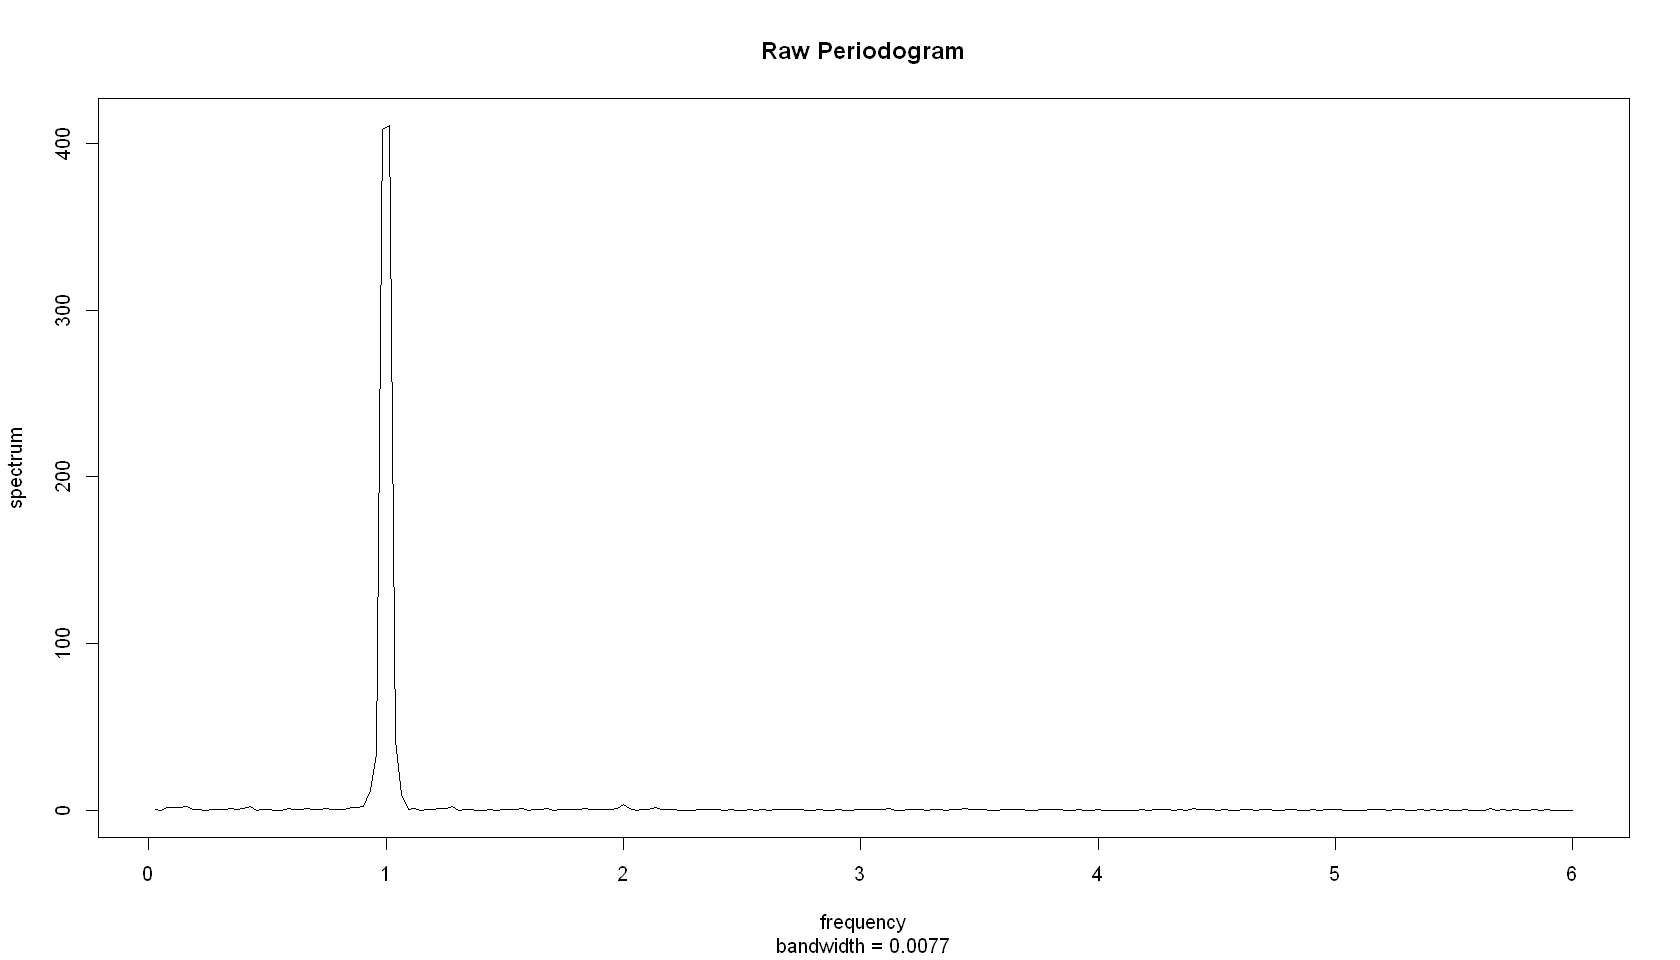

In [10]:
spec.pgram(train, log="no", main="Raw Periodogram")

### 3.2 Stationarity

> Seasonal differencing is the difference between the observation and corresponding observation from pervious year.
$$
y_t' = y_t - y_{t-12}
$$
After taking the first seasonal difference, the time series do look staionary.

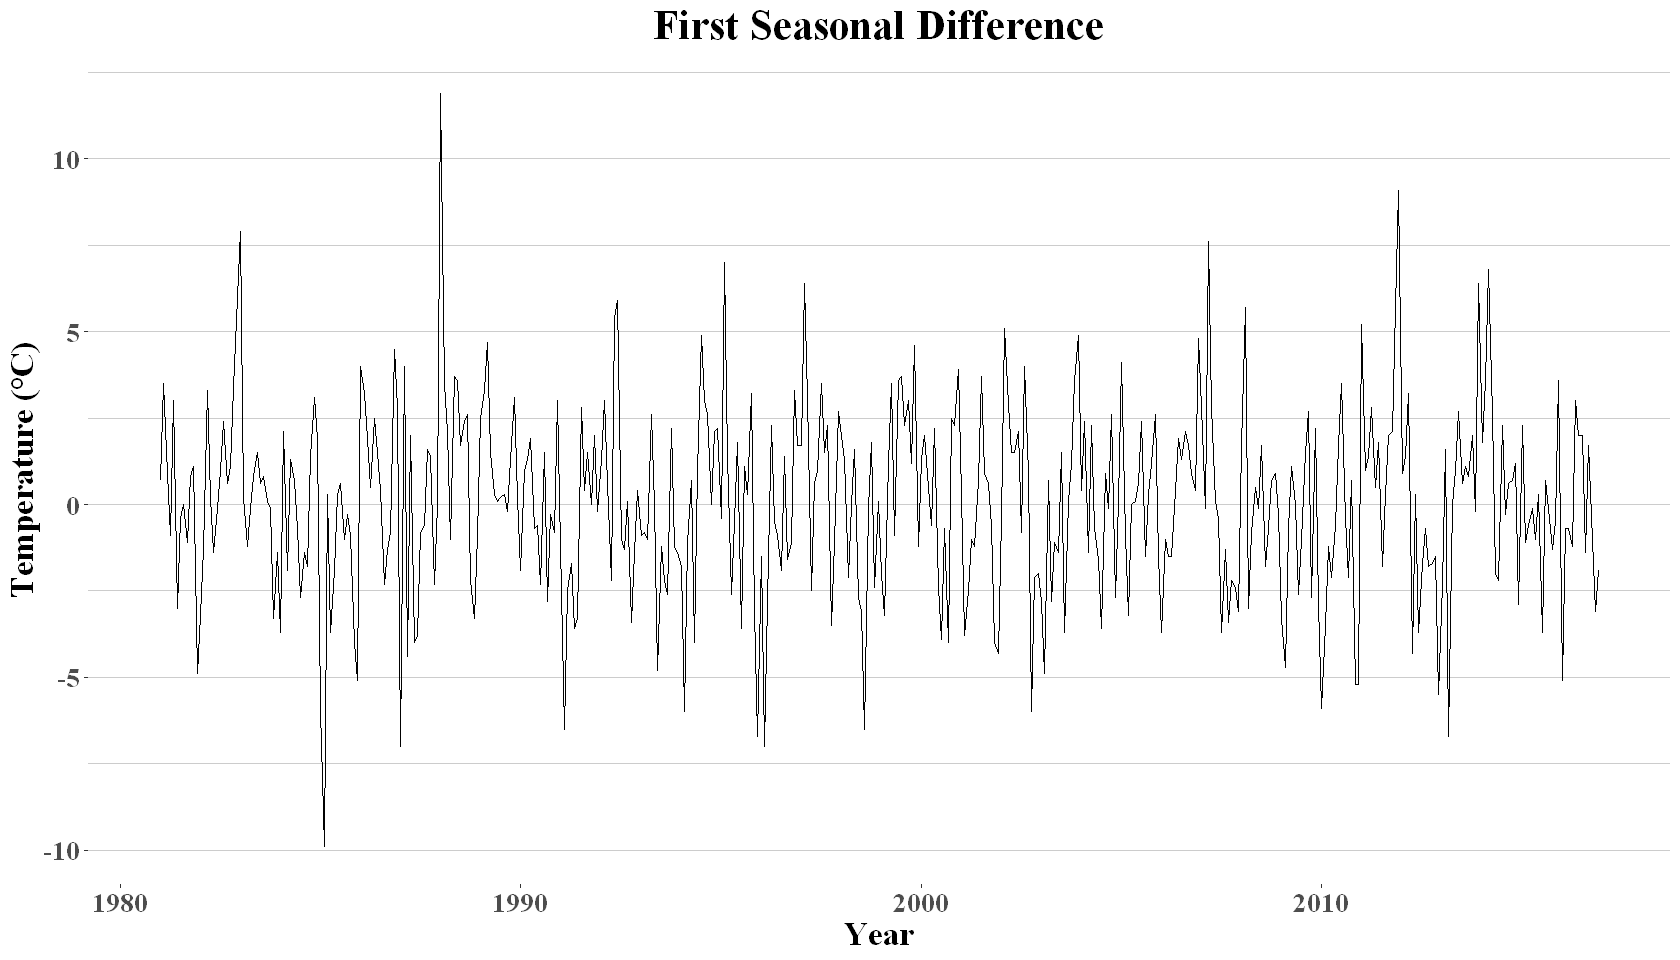

In [11]:
#collapse
# Seasonal difference
train.diff = diff(train, lag=12)
autoplot(train.diff, xlab="Year", ylab="Temperature (°C)")+
    ggtitle("First Seasonal Difference")+ 
    th + 
    guides(colour = guide_legend(title.hjust = 20))

**Augmented Dicker-Fuller test**. 

> Rejection of null hypothesis, evidence of stationarity. It should be noted however most unit root tests do have a high type 1 error rate, that is incorrect rejection of a true null hypothesis.

In [12]:
adf.test(train.diff)

Warning message in adf.test(train.diff):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train.diff
Dickey-Fuller = -6.5205, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


**Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**.

> Check if the time series is stationary around a deterministic trend. Presence of unit root is not the null hypothesis but rather the alternative.

In [13]:
kpss.test(train.diff)

Warning message in kpss.test(train.diff):
"p-value greater than printed p-value"



	KPSS Test for Level Stationarity

data:  train.diff
KPSS Level = 0.021325, Truncation lag parameter = 5, p-value = 0.1


### 3.3 Possible transformations

> The dataset has some problematic characteristics which might not be captured by an ordinary ARIMA model. Our training period is long, with 40 years of observations. How old observations are still relevant in predicting future temperature? Signs of structural breaks have been spotted and it might prove wise to use a shorter training period.

## 4. Model building
Modeling will be done through manual configuration as well as automatic selection. Our chosen model will be investigated for residual errors.

Let d and D be nonnegative integers, then {$X_t$} is a $SARIMA(p, d, q)\times(P,D,Q)_s$ process is defined by

$$
\phi(B) \Phi(B^s) (1-B)^d (1-B^s)^DX_t = \theta(B) \Theta(B^s) Z_t, \quad {Z_t} \sim WN(0, \sigma^2)
$$

where 
* $\phi(z) = 1- \phi_1 z - ... - \phi_p z^p $
* $\Phi(z) = 1- \Phi_1 z - ... - \Phi_P z^P $
* $\theta(z)= 1- \theta_1 z - ... - \theta_q z^q $
* $\Theta(z)= 1- \Theta_1 z - ... - \Theta_Q z^Q $


### 4.1 Manually configured

> Both the ACF and PACF have nonseasonal spikes at lag 1 which are then cut off. This would suggest starting with having p and q equal to one. The ACF has a seasonal spike at lag 12 which then cuts off, while PACF seasonal spikes tails off. It would suggest our time series being described by a seasonal moving average model with one seasonal term (Q = 1). 
$$
\text{ARIMA}(1,0,1) \times (0, 1, 1)_{12}
$$

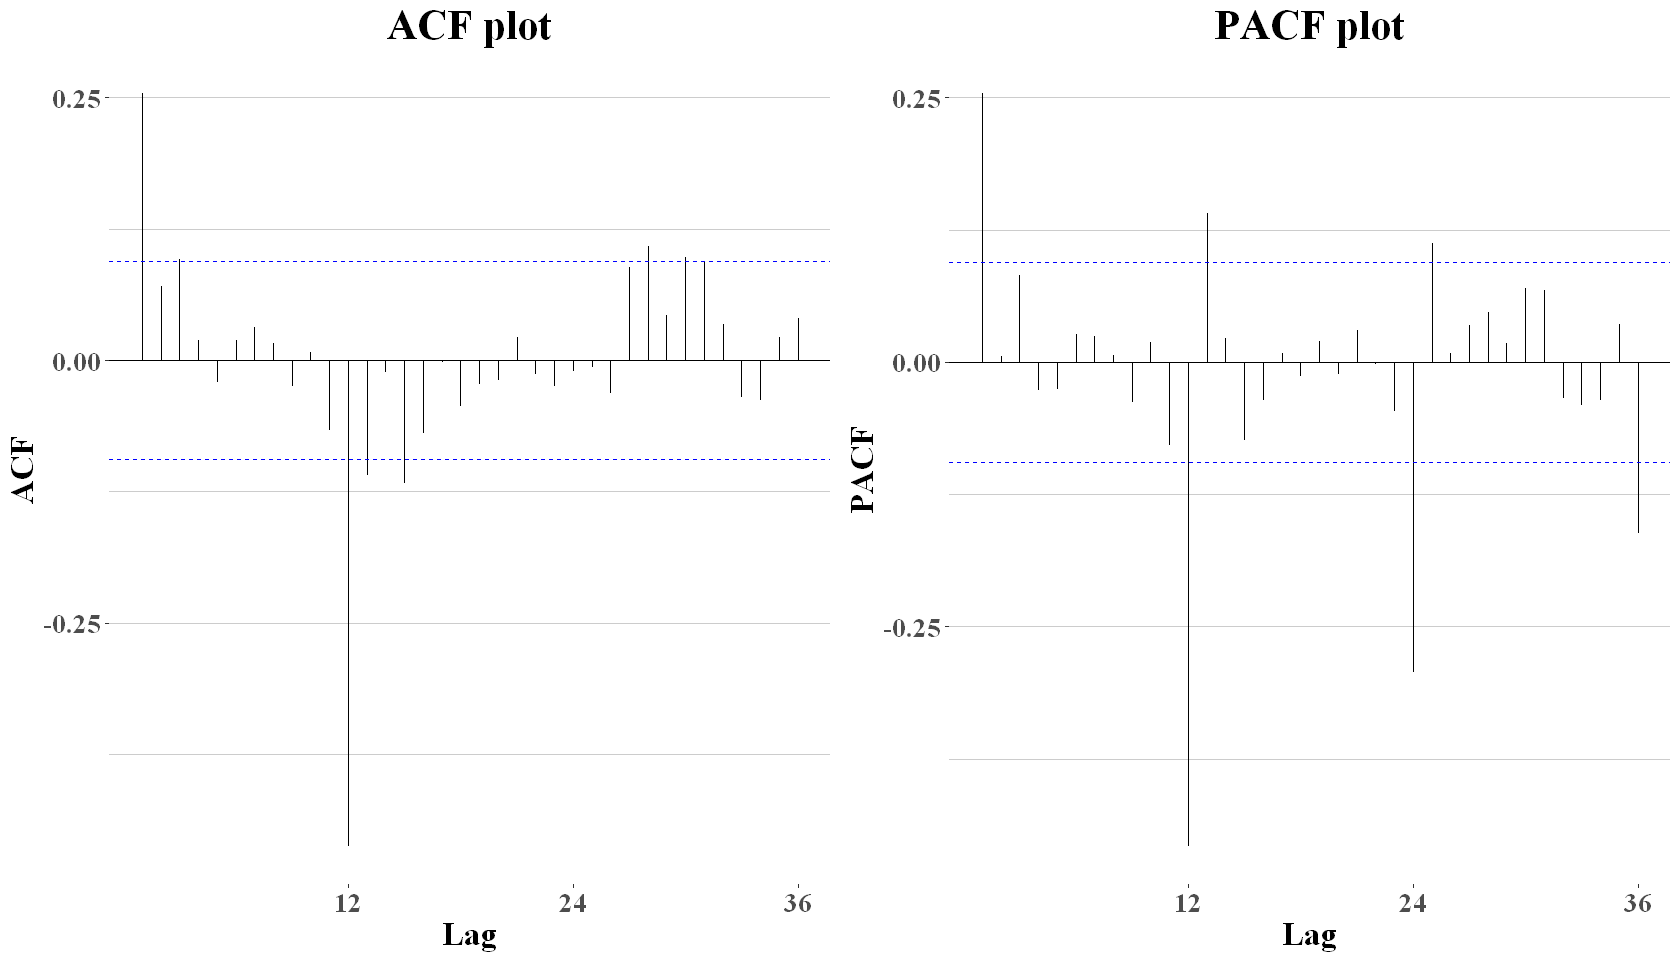

In [14]:
#collapse
p1 = ggAcf(train.diff, lag.max = 36) +
    ggtitle("ACF plot")+ 
    th

p2 = ggPacf(train.diff, lag.max = 36) +
    ggtitle("PACF plot")+ 
    th

grid.arrange(p1, p2, ncol=2)

### 4.2 Automatic configuration

> One automatic configuration would be a grid search of hyperparameters. The model with lowest AIC came out to be the same model as our manual configuration apart from one additional autoregressive term.

In [15]:
#collapse
p <- q <- P <- Q <- 0:3
grid <- expand.grid(p=p, q=q, P=P, Q=Q)
grid$k <- rowSums(grid)
grid <- grid %>% filter(k<=4)

arima_search <- lapply(1:nrow(grid), function(i){
    mdl <- NULL
    mdl <- try(arima(train, order=c(grid$p[i], 0, grid$q[i]), 
                     seasonal=list(order=c(grid$P[i], 1, grid$Q[i]), period=12),
                     optim.control = list(maxit = 1000)))
    
    aic_scores <- data.frame(p = grid$p[i], d=0, q=grid$q[i], P=grid$P[i], D=1, Q=grid$Q[i], AIC = mdl$aic)
}) %>% bind_rows() %>% arrange(AIC)

head(arima_search)

,p,d,q,P,D,Q,AIC
,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,2,0,1,0,1,1,1828.729
2,1,0,2,0,1,1,1832.071
3,1,0,0,0,1,1,1834.952
4,1,0,0,1,1,2,1835.330
5,1,0,1,0,1,1,1836.200
6,2,0,0,0,1,1,1836.403


> **Auto arima** does not return the model with lowest AIC score, but has several requirements for what is considered a good model. It will not return models with roots close to the unit circle since forecasts would be numerically unstable.

In [16]:
mdl = auto.arima(train)
print(mdl)

Series: train 
ARIMA(0,0,2)(2,1,0)[12] with drift 

Coefficients:
         ma1     ma2     sar1     sar2   drift
      0.3054  0.0881  -0.6507  -0.3184  0.0054
s.e.  0.0478  0.0467   0.0467   0.0459  0.0063

sigma^2 = 4.877:  log likelihood = -955.75
AIC=1923.51   AICc=1923.71   BIC=1947.92


## 5. Diagnostic checking
> Let us investigare our manually configered model.
$$
\text{ARIMA}(1,0,1) \times (0, 1, 1)_{12}
$$


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1)(0,1,1)[12]
Q* = 16.774, df = 21, p-value = 0.7247

Model df: 3.   Total lags used: 24




	Box-Pierce test

data:  mdl$residuals
X-squared = 0.12694, df = 1, p-value = 0.7216


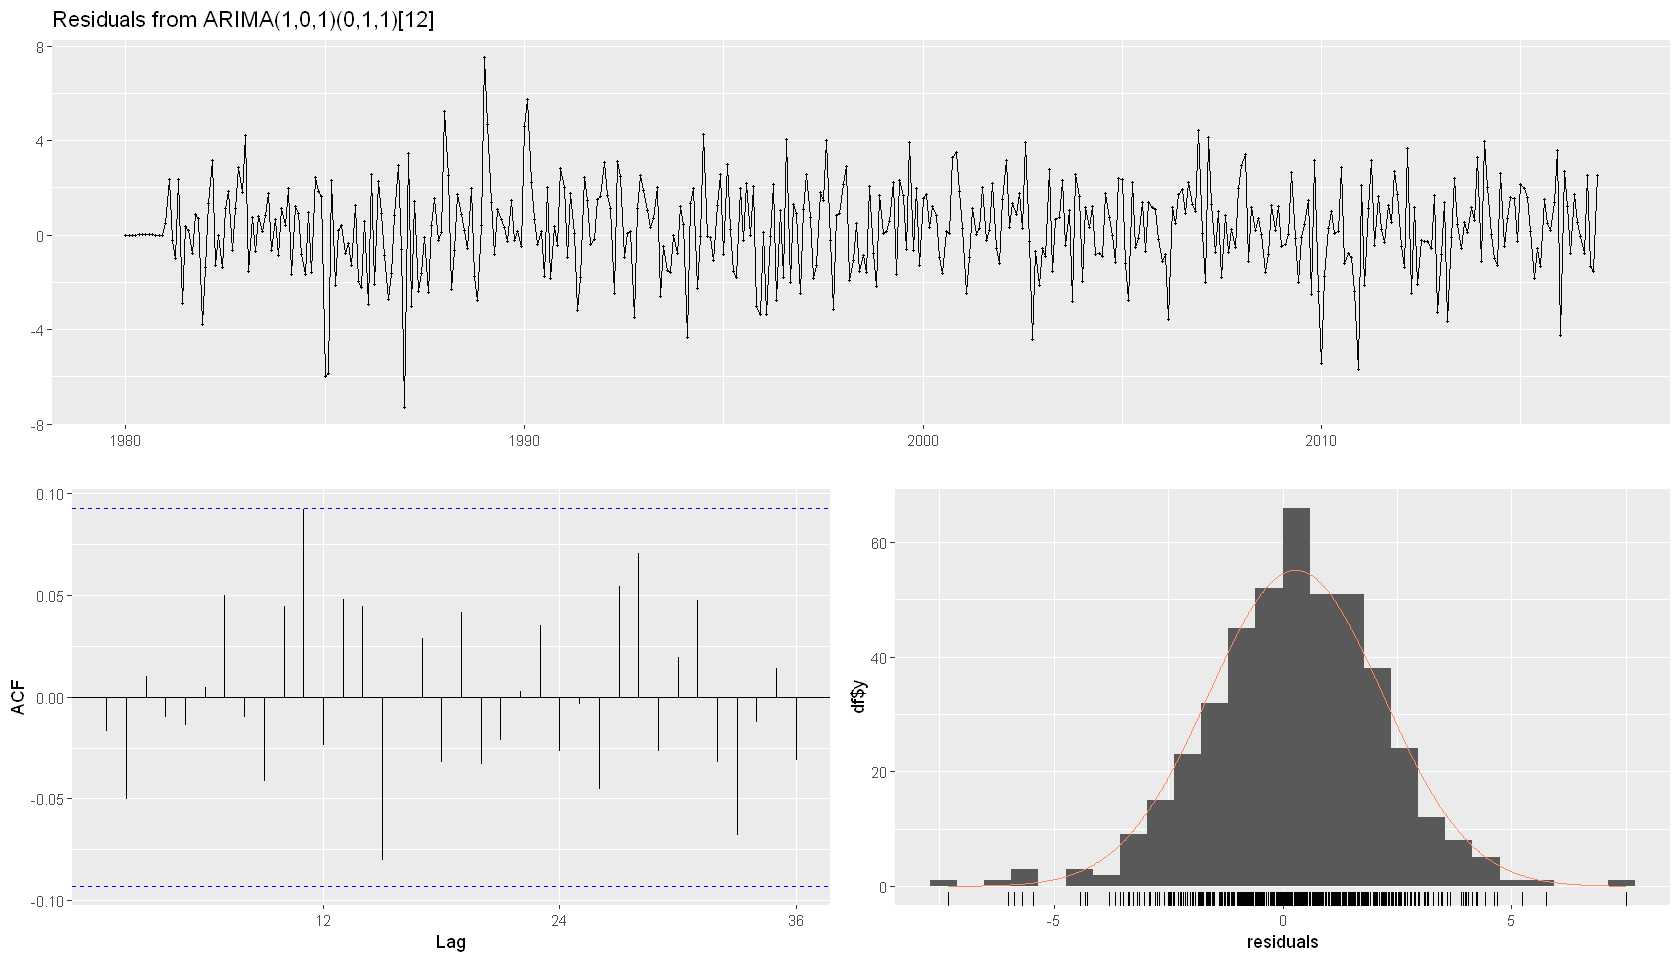

In [17]:
mdl <- arima(train, order = c(1, 0, 1), seasonal=list(order=c(0,1,1)), optim.control = list(maxit = 1000))
checkresiduals(mdl)
Box.test(mdl$residuals)

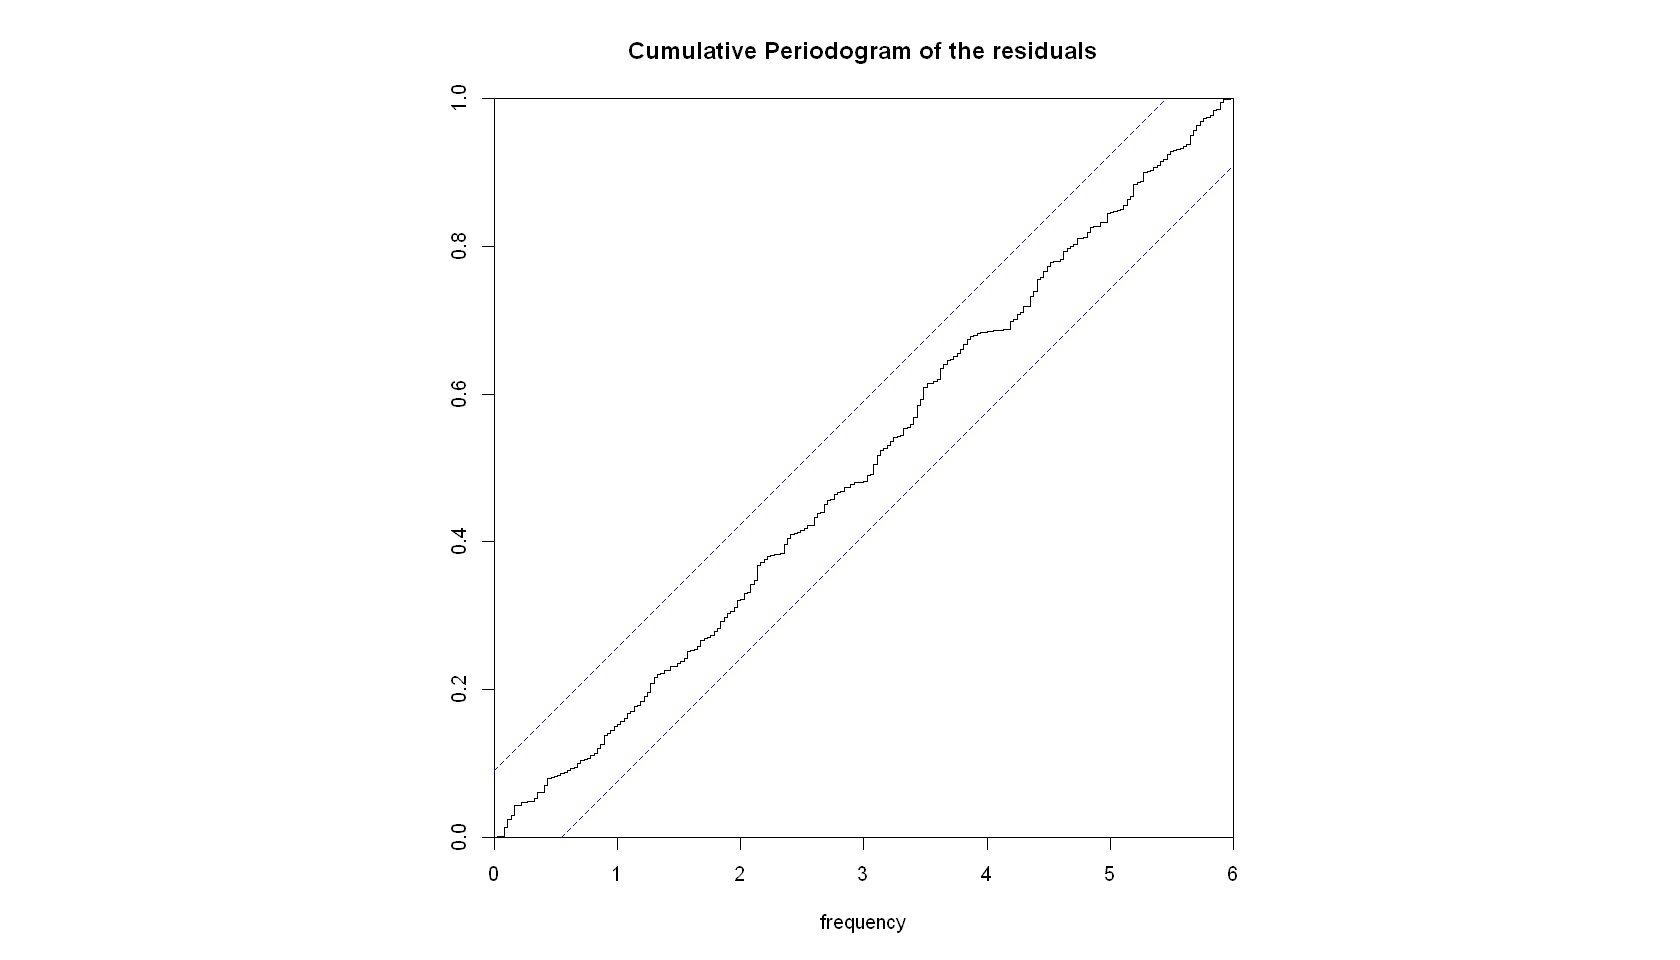

In [18]:
cpgram(mdl$residuals, main="Cumulative Periodogram of the residuals")

> A shipiro wilk-test would reveale evidence against residuals being normally distributed. The QQ-plot help in identifying this departure and it becomes apparent our seasonal outliers are not captured in the model. This is unfortunately a limitation of ARIMA models.


	Shapiro-Wilk normality test

data:  mdl$residuals
W = 0.99006, p-value = 0.004272


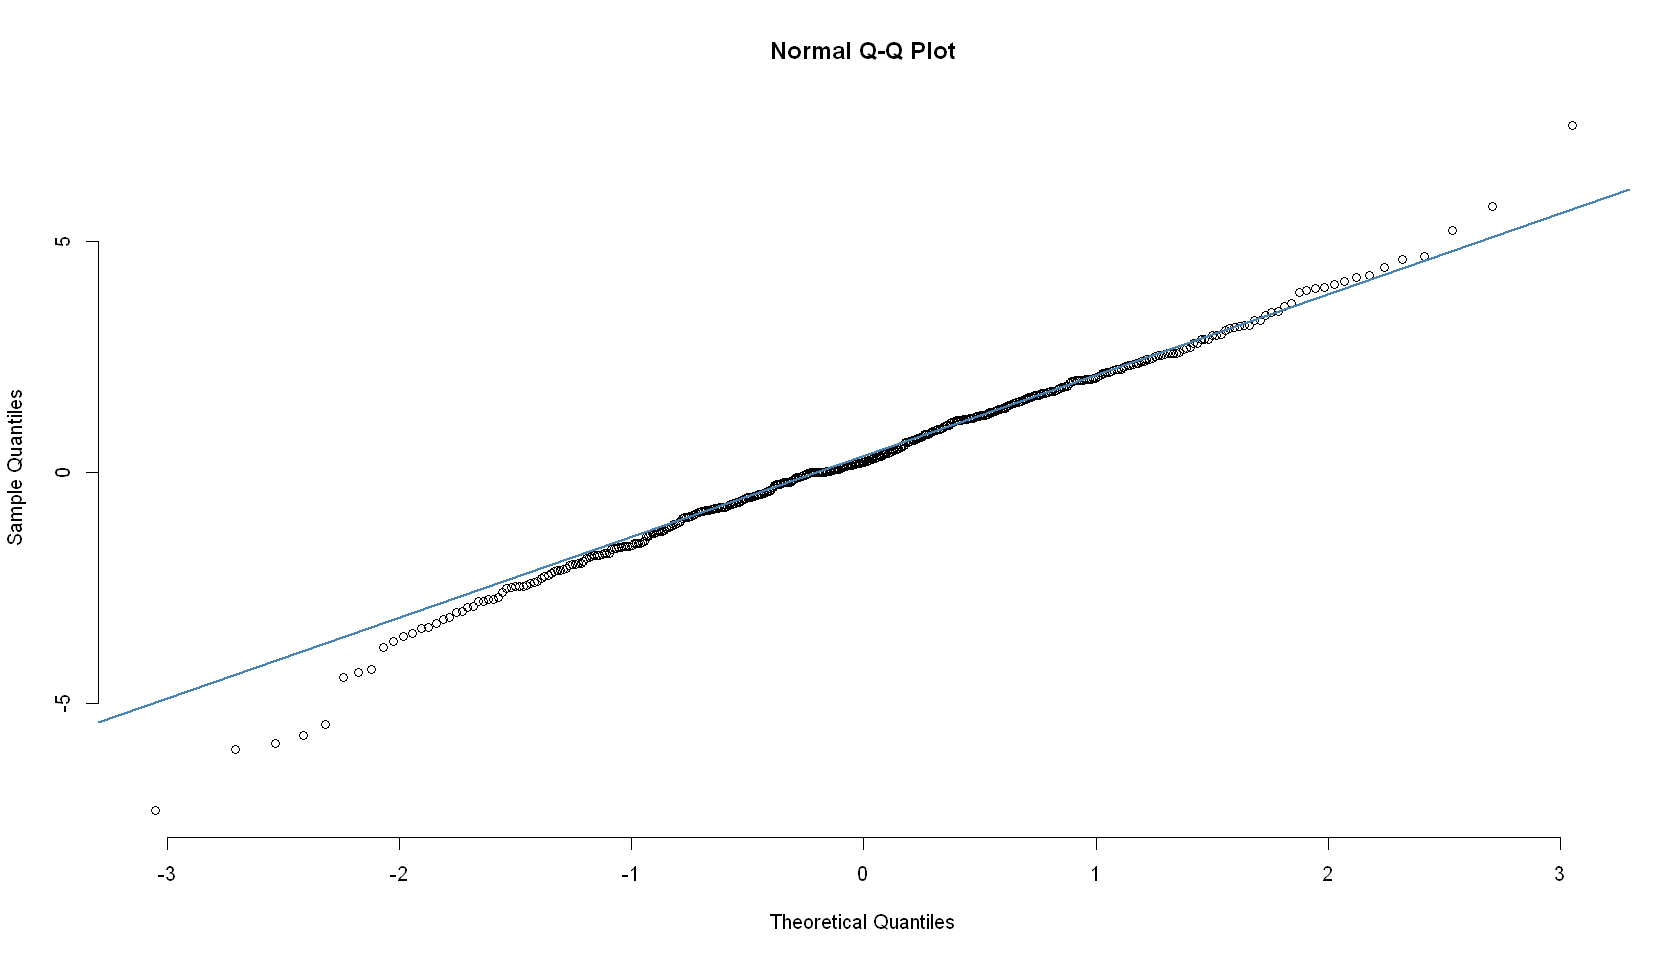

In [19]:
#collapse
qqnorm(mdl$residuals, pch=1, frame=FALSE)
qqline(mdl$residuals, col="steelblue", lwd=2)
shapiro.test(mdl$residuals)

## 6. Forecasting
> Let us try and forecast with out model
$$
\text{ARIMA}(1,0,1) \times (0, 1, 1)_{12}
$$

In [20]:
#collapse
pred <- predict(mdl, n.ahead=48)

pred_reshape <- data.frame(date=as.Date(as.yearmon(time(pred$pred))), pred=as.matrix(pred$pred))
se_reshape <- data.frame(date=as.Date(as.yearmon(time(pred$se))), se=as.matrix(pred$se))
test_reshape <- data.frame(date=as.Date(as.yearmon(time(test))), temp=as.matrix(test))
predict <- merge(pred_reshape, se_reshape, by="date") %>% merge(test_reshape, by="date")

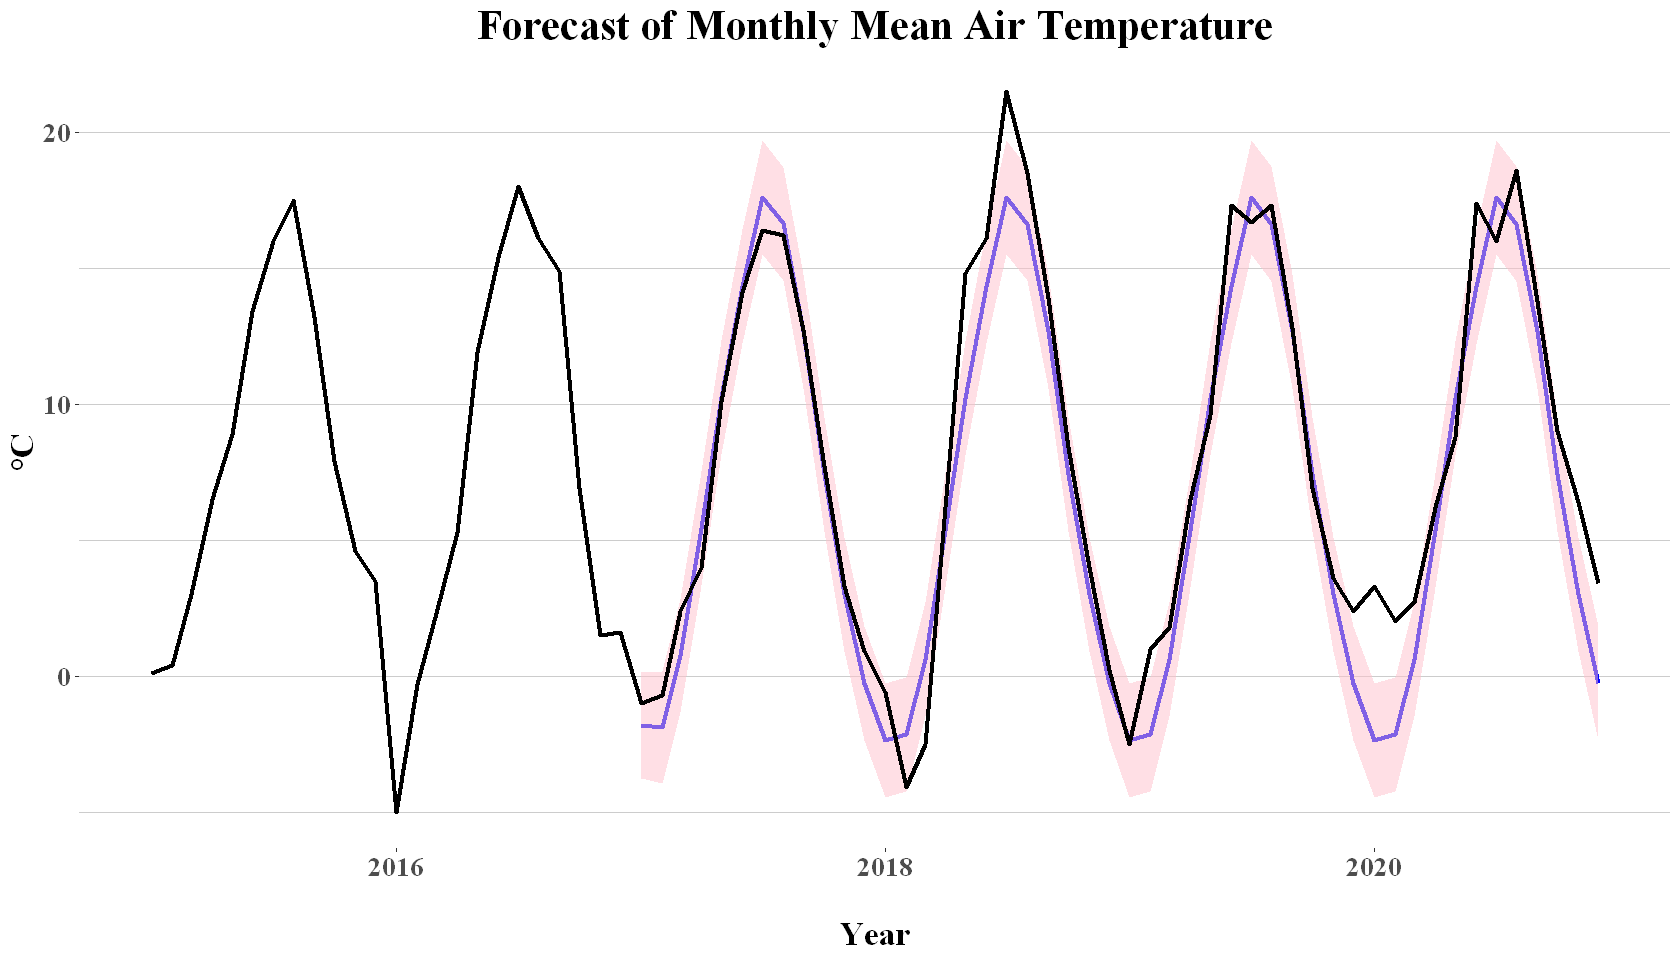

In [21]:
#collapse
ggplot() +
    #geom_line(data=predict, aes(x=date, y = pred+se), color="red") +
    #geom_line(data=predict, aes(x=date, y = pred-se), color="red") +
    geom_line(data=predict, aes(x=date, y = pred), color="blue", size=1.3) +
    geom_ribbon(data=predict, aes(x=date, ymax=pred+se, ymin=pred-se), fill="pink", alpha=.5) +
    geom_line(data=tail(rbind(train_reshape[,c("date", "temp")], test_reshape), n=72), aes(x=date, y = temp), size=1.2) + 
    ggtitle("Forecast of Monthly Mean Air Temperature") +
    xlab("\nYear") + ylab("°C") +
    th

> Our forecast is doing a good job, but can certainly be improved. Our confidence interval is not able to catch seasonal deviations.

## 7. Further improvements
Residuals are not normally distributed and a better model can be found, but it will require more work with the underlying data or the use of a more complex model. 

A GARCH model would capture the conditional variance and might give better result than ARIMA could in this case.

Seasonal outliers are not captured by the model. Potentially use less training data and thus avoid seasonal outliers. One must thus determain how long training data is optimal.